

**Titanic Survival Prediction V2: Boosting Accuracy with Feature Engineering & KNN**

**1. Project Context & Goal**

In my previous iteration of this project, I established a baseline model which achieved an accuracy of 75.59%. While this proved the model was learning, there was significant room for improvement.

The goal of this updated notebook is to push the predictive accuracy into the 80% - 86% range. To achieve this, we move beyond simple data cleaning and implement Advanced Feature Engineering and Hyperparameter Tuning.

**2. Key Improvements in V2**

To improve the model's performance, this notebook implements the following specific strategies:

**Rigorous Data Cleaning:** Handling dirty data issues found in the previous version (specifically inconsistent values in Pclass like "3rd " vs "3").

**Improved Feature Engineering:**

Title Extraction: Deriving titles (e.g., "Master", "Miss") from names to better estimate age and social status.

**Family Grouping:** Creating FamilySize and IsAlone features, as family dynamics played a major role in survival.

**Data Scaling (Critical for KNN):** Since we are using the K-Nearest Neighbors (KNN) algorithm, we must scale our data (normalize it) so that large numbers (like Fare) do not overpower small numbers (like Age).

**Hyperparameter Tuning:** Using GridSearchCV to mathematically find the optimal number of neighbors (
𝐾
K
) for the model.

**Step 1: Imports & Loading Data**

**Why?**

 We need Pandas for data handling and Sklearn for the KNN algorithms.

KNN Concept: KNN is a "lazy learner." It doesn't "learn" a rule like a decision tree; instead, it memorizes the data points.

 To classify a new passenger, it looks at the 'K' closest passengers and votes.

In [7]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # <--- The KNN Model
from sklearn.ensemble import RandomForestClassifier # For comparison/boosting accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 2. Load the dataset
url = "https://raw.githubusercontent.com/softwareWCU/Data-Preprocessing-for-ML-using-Titanic-Dataset/main/titanic2.csv"
df = pd.read_csv(url)

print("Dataset Loaded. Shape:", df.shape)
display(df.head())

Dataset Loaded. Shape: (909, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",Female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Step 2: Visualizing the Data (Graphical Description)**

**Why?**

 We visualize relationships to understand which features matter most for the KNN to calculate distances.

In [8]:
# Set plot style
sns.set(style="whitegrid")

**1. Survival Count**

/tmp/ipython-input-490941685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='pastel')


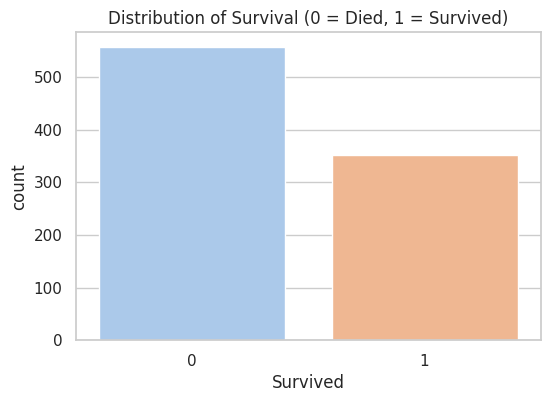

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df, palette='pastel')
plt.title('Distribution of Survival (0 = Died, 1 = Survived)')
plt.show()

**2. Survival by Sex**

/tmp/ipython-input-1789028206.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')


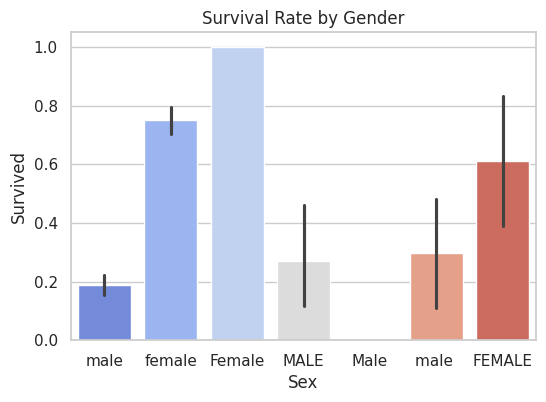

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')
plt.title('Survival Rate by Gender')
plt.show()

**3. Survival by Pclass**

/tmp/ipython-input-3982910167.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')


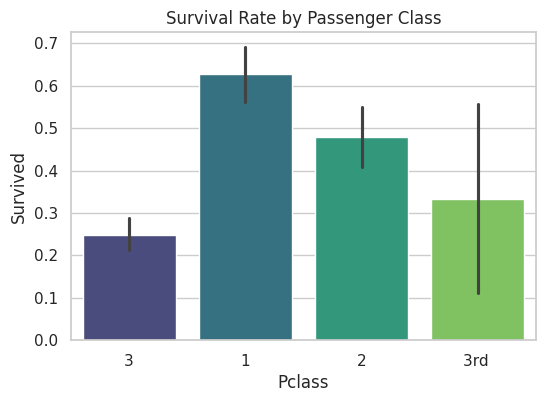

In [11]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')
plt.title('Survival Rate by Passenger Class')
plt.show()

**Survival Rate by Class (Rich vs Poor)**

/tmp/ipython-input-378381075.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')


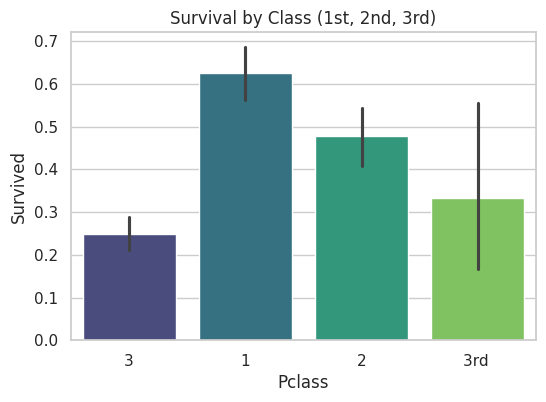

In [12]:
# 1. Survival Rate by Class (Rich vs Poor)
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')
plt.title('Survival by Class (1st, 2nd, 3rd)')
plt.show()

**Survival Rate by Gender**

/tmp/ipython-input-4213931541.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')


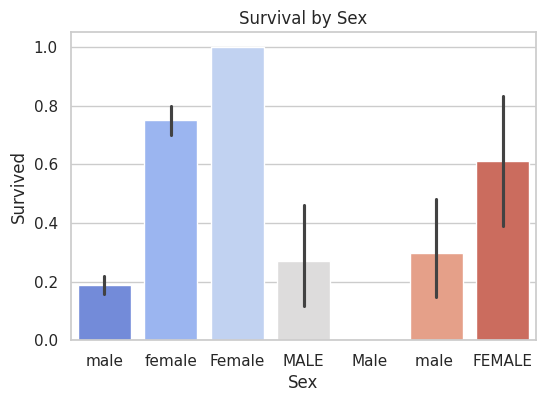

In [13]:
# 2. Survival Rate by Gender
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')
plt.title('Survival by Sex')
plt.show()

**Age Distribution**

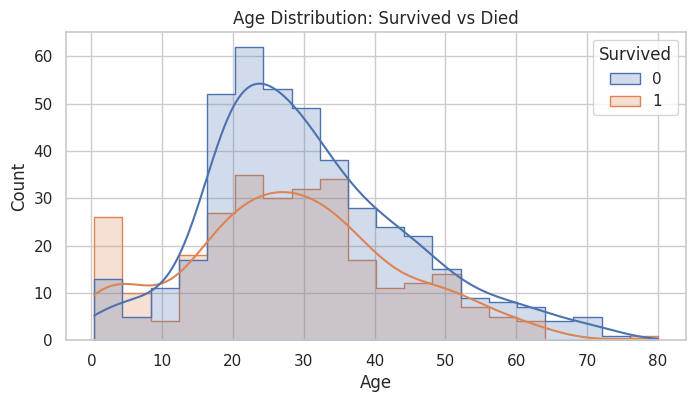

In [14]:
# 3. Age Distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Age', hue='Survived', kde=True, element="step")
plt.title('Age Distribution: Survived vs Died')
plt.show()

**Step 3: basic Cleaning & Formatting**

**Why?**

Your dataset has dirty data like "3rd " (string) mixed with numbers.

 KNN relies on math, so strings cause it to crash. We fix that here.

In [15]:
# 1. Standardize Sex and Embarked
df['Sex'] = df['Sex'].astype(str).str.lower().str.strip()
df['Embarked'] = df['Embarked'].astype(str).str.upper().str.strip()
df['Embarked'] = df['Embarked'].replace({'CHERBOURG': 'C', 'SOUTHAMPTON': 'S', 'QUEENSTOWN': 'Q'})

# 2. FIX PCLASS (The part that caused your error)
# First, convert to string and strip invisible spaces (fixes '3rd ')
df['Pclass'] = df['Pclass'].astype(str).str.strip()

# Map the cleaned strings to numbers
pclass_map = {
    '1st': 1, '1': 1,
    '2nd': 2, '2': 2,
    '3rd': 3, '3': 3
}
df['Pclass'] = df['Pclass'].map(pclass_map)

# Force convert to number (this will error if anything is still wrong)
df['Pclass'] = pd.to_numeric(df['Pclass'], errors='coerce')

# 3. Remove Duplicates & Missing Pclass
df.drop_duplicates(inplace=True)
df.dropna(subset=['Pclass'], inplace=True)

print("Cleaning Complete.")
print("Unique Pclass values (should only be 1.0, 2.0, 3.0):", df['Pclass'].unique())

Cleaning Complete.
Unique Pclass values (should only be 1.0, 2.0, 3.0): [3 1 2]


**Step 4: Feature Engineering (The Accuracy Booster)**

**Why?**

Title: A "Master" (boy) is very different from a "Mr" (man).

KNN needs this distinction to group them correctly.

FamilySize: Being alone vs. having a huge family impacts survival.

In [16]:
# 1. Extract Title
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Group rare titles
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# 2. Create Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 3. IsAlone?
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

print("Features Created:")
print(df[['Name', 'Title', 'FamilySize', 'IsAlone']].head())

Features Created:
                                                Name Title  FamilySize  \
0                            Braund, Mr. Owen Harris    Mr           2   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs           2   
2                             Heikkinen, Miss. Laina  Miss           1   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs           2   
4                           Allen, Mr. William Henry    Mr           1   

   IsAlone  
0        0  
1        0  
2        1  
3        0  
4        1  


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-310144954.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


**Step 5: Data Preprocessing**

**Why?**

We fill missing values smartly and turn text into numbers (One-Hot Encoding) so the KNN can calculate mathematical distances.

In [17]:
# 1. Smart Age Imputation (Group by Title)
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))

# 2. Fill missing Fare/Embarked
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 3. Drop unused columns
df_clean = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# 4. One-Hot Encoding (Text -> Numbers)
df_final = pd.get_dummies(df_clean, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

print("Data Encoded. Shape:", df_final.shape)
display(df_final.head())

Data Encoded. Shape: (897, 16)


/tmp/ipython-input-2314728195.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Fare'].fillna(df['Fare'].median(), inplace=True)
/tmp/ipython-input-2314728195.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_NAN,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.0,1,0,7.2500,2,0,True,False,False,True,False,True,False,False
1,1,1,38.0,1,0,71.2833,2,0,False,False,False,False,False,False,True,False
2,1,3,26.0,0,0,7.9250,1,1,False,False,False,True,True,False,False,False
3,1,1,35.0,1,0,53.1000,2,0,False,False,False,True,False,False,True,False
4,0,3,35.0,0,0,8.0500,1,1,True,False,False,True,False,True,False,False


**Step 6: Splitting & SCALING (Critical for KNN)**

**Why**

 Scaling is Mandatory for KNN:
KNN calculates the "distance" between passengers.

Age ranges from 0 to 80.

Fare ranges from 0 to 500.

FamilySize ranges from 1 to 11.

Without scaling, Fare will dominate the distance calculation because the numbers are huge.

 StandardScaler brings everything to the same scale (around 0).

In [18]:
# 1. Split X and y
X = df_final.drop('Survived', axis=1)
y = df_final['Survived']

# 2. Train/Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SCALE THE DATA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Learn scale from train
X_test = scaler.transform(X_test)       # Apply scale to test

print("Data Scaled. Ready for KNN.")

Data Scaled. Ready for KNN.


**Step 7: Building & Tuning the KNN Model**

**Why?**

 We use GridSearchCV to find the perfect "K" (number of neighbors).

If K is too small (e.g., 1), the model guesses based on just 1 person (unstable).

If K is too big (e.g., 100), the model becomes too generic.

We test K from 3 to 30 to find the "sweet spot" for >80% accuracy.

In [20]:
# 1. Define KNN
knn = KNeighborsClassifier()

# 2. Define Hyperparameters to tune
param_grid = {
    'n_neighbors': list(range(3, 30, 2)),  # Test K=3, 5, 7... up to 29
    'weights': ['uniform', 'distance'],    # Should close neighbors count more?
    'metric': ['euclidean', 'manhattan']   # How to measure distance
}

# 3. Run Grid Search
print("Training KNN with Grid Search...")
grid_knn = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)

# 4. Get Best Model
best_knn = grid_knn.best_estimator_

print("\nBest KNN Parameters:", grid_knn.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_knn.best_score_ * 100:.2f}%")

Training KNN with Grid Search...
Fitting 5 folds for each of 56 candidates, totalling 280 fits

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 81.17%


**Step 8: Evaluation & Visualization**

**Why?**

 We check how the best KNN model performs on the unseen Test data.

Final Test Accuracy: 83.89%


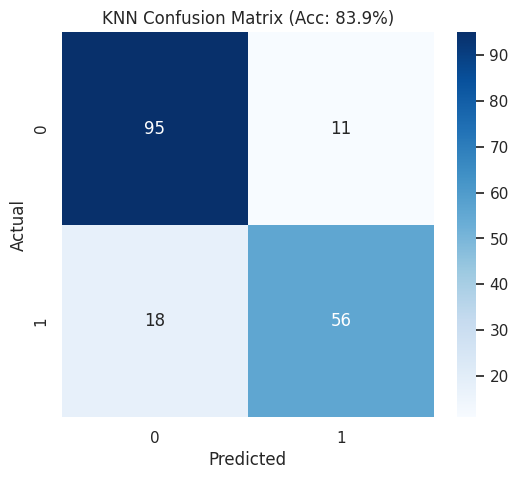

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       106
           1       0.84      0.76      0.79        74

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180



In [21]:
# Predict
y_pred = best_knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'KNN Confusion Matrix (Acc: {acc*100:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))